In [2]:
#Data Importation from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import itertools
import time
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
stemma = PorterStemmer()
from tqdm import tqdm
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# LOADING OF DATA

In [4]:
data_path = "/content/drive/MyDrive/Colab Notebooks/ADAML/bbc-text.csv"

In [5]:
df =  pd.read_csv(data_path)
df.head()


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


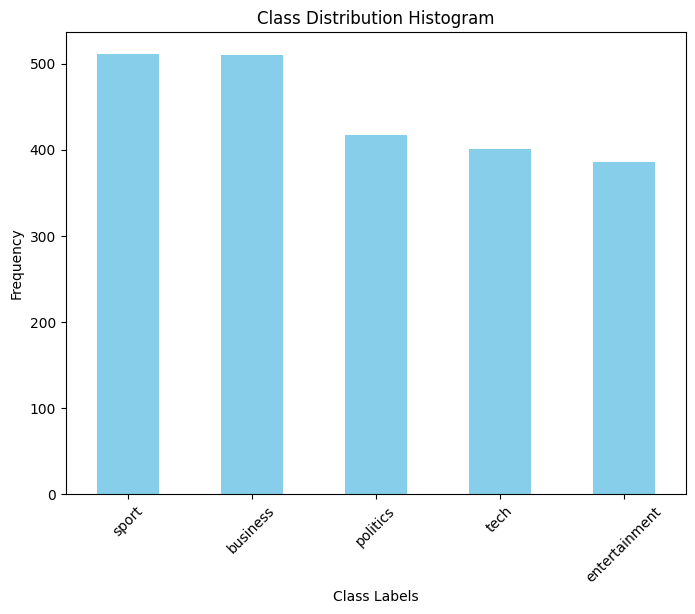

In [ ]:
#Data visualization

plt.figure(figsize=(8, 6))
df['category'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution Histogram')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df.category.unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [6]:
df['category'].replace({'tech': 0, 'sport': 1, 'entertainment':2, 'business':3,'politics':4}, inplace=True)
df.head()

<ipython-input-6-e2246349e701>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['category'].replace({'tech': 0, 'sport': 1, 'entertainment':2, 'business':3,'politics':4}, inplace=True)
<ipython-input-6-e2246349e701>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['category'].replace({'tech': 

,category,text
0,0,tv future in the hands of viewers with home th...
1,3,worldcom boss left books alone former worldc...
2,1,tigers wary of farrell gamble leicester say ...
3,1,yeading face newcastle in fa cup premiership s...
4,2,ocean s twelve raids box office ocean s twelve...


In [7]:
# Extract text and labels
texts = df['text'].values
labels = df['category'].values


In [ ]:
word_ext = []
num_texts = len(texts)
counter = 0
while counter < num_texts:
    text = texts[counter]
    text = re.sub('[^a-zA-Z]', ' ', str(text)).lower()
    atext = re.sub(' +',' ',str(text))
    words = nltk.word_tokenize(atext)
    atext = [stemma.stem(word)for word in words if word not in stopwords.words('english')]
    text = ' '.join(atext)
    word_ext.append(text.strip())
    counter += 1

In [ ]:
len(word_ext[0])

2527

In [ ]:
word_count = []
for elements in word_ext:
  word_count.append(len(elements.split()))
print(max(word_count))

2198


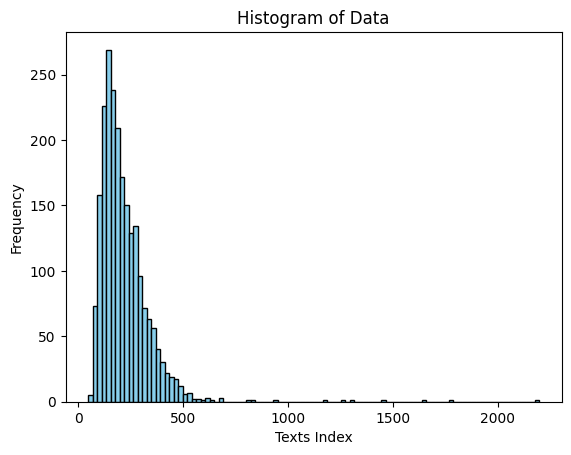

In [ ]:
import matplotlib.pyplot as plt
# Create the histogram
plt.hist(word_count, bins=100, color='skyblue', edgecolor='black')

# Add title and labels
plt.title('Histogram of Data')
plt.xlabel('Texts Index')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [8]:
# Split the dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Display shapes of the splits
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Verify the first sample
print("First training sample:", X_train[0], "Label:", y_train[0])

Training set size: 1780
Test set size: 445
First training sample: screensaver tackles spam websites net users are getting the chance to fight back against spam websites  internet portal lycos has made a screensaver that endlessly requests data from sites that sell the goods and services mentioned in spam e-mail. lycos hopes it will make the monthly bandwidth bills of spammers soar by keeping their servers running flat out. the net firm estimates that if enough people sign up and download the tool  spammers could end up paying to send out terabytes of data.   we ve never really solved the big problem of spam which is that its so damn cheap and easy to do   said malte pollmann  spokesman for lycos europe.  in the past we have built up the spam filtering systems for our users   he said   but now we are going to go one step further.    we ve found a way to make it much higher cost for spammers by putting a load on their servers.  by getting thousands of people to download and use the scree

In [9]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, BertConfig

In [10]:
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.nn.functional as F

In [11]:
# Custom Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [12]:
# Training function
def train_model(model, train_loader, val_loader, optimizer, device, epochs):
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    model = model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask)
            logits = outputs.logits

            loss = F.cross_entropy(logits, labels)

            total_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()

        # Training stats
        train_acc = correct / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {train_acc:.4f}")
        # Validation
        val_l, val_a= validate_model(model, val_loader, device)
        train_accuracy.append(train_acc)
        train_loss.append(total_loss)
        val_loss.append(val_l)
        val_accuracy.append(val_a)
    return train_loss, train_accuracy, val_loss , val_accuracy



In [13]:
# Validation function
def validate_model(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    los_t =0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask)
            loss = F.cross_entropy(outputs.logits, labels)

            los_t += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    print(f"Validation Accuracy: {val_acc:.4f}")
    return los_t, val_acc


In [14]:
# Example Training Code
from transformers import BertForSequenceClassification

In [15]:

# Parameters
pretrained_model_name = "bert-base-uncased"
num_classes = 5
max_length = 100
batch_size = 64
learning_rate = 3e-5
epochs = 5

# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)

# Datasets and DataLoaders
train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextDataset(val_texts, val_labels, tokenizer, max_length)
test_dataset = TextDataset(X_test, y_test, tokenizer, max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [16]:
 # Model and Optimizer
Bert_model = BertForSequenceClassification.from_pretrained(pretrained_model_name_or_path=pretrained_model_name, num_labels = num_classes)

optimizer = AdamW(Bert_model.parameters(), lr=learning_rate)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
Bert_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
    # Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tr_l,tr_acc, v_l, v_a = train_model(Bert_model, train_loader, val_loader, optimizer, device, epochs)

100%|██████████| 23/23 [00:33<00:00,  1.44s/it]


Epoch 1/5, Loss: 25.7123, Accuracy: 0.6454
Validation Accuracy: 0.9522


100%|██████████| 23/23 [00:33<00:00,  1.46s/it]


Epoch 2/5, Loss: 7.1959, Accuracy: 0.9712
Validation Accuracy: 0.9719


100%|██████████| 23/23 [00:36<00:00,  1.59s/it]


Epoch 3/5, Loss: 2.1075, Accuracy: 0.9888
Validation Accuracy: 0.9860


100%|██████████| 23/23 [00:36<00:00,  1.59s/it]


Epoch 4/5, Loss: 0.9595, Accuracy: 0.9965
Validation Accuracy: 0.9803


100%|██████████| 23/23 [00:35<00:00,  1.52s/it]


Epoch 5/5, Loss: 0.5193, Accuracy: 0.9993
Validation Accuracy: 0.9719


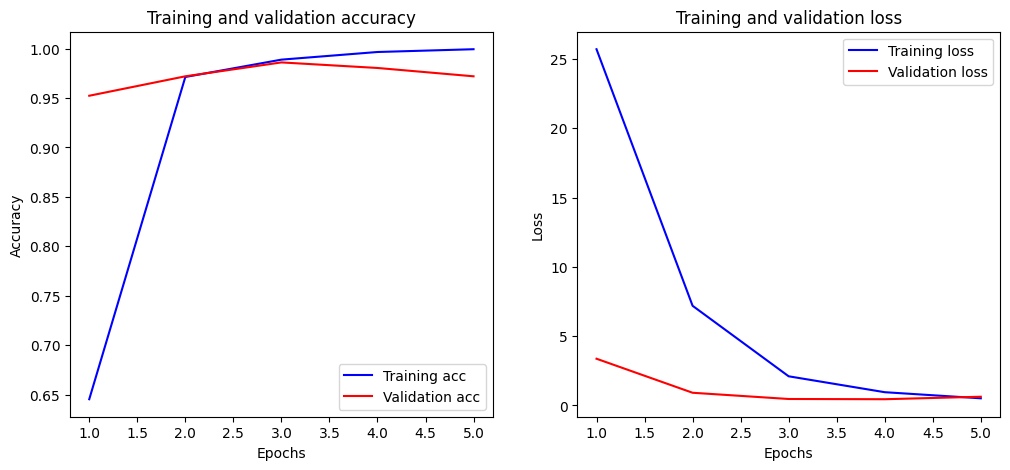

In [ ]:
import matplotlib.pyplot as plt

# Assuming tr_l, tr_acc, v_l, v_a are available from your training

epochs = range(1, len(tr_l) + 1)  # Epochs start from 1

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_acc, 'b', label='Training acc')
plt.plot(epochs, v_a, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, tr_l, 'b', label='Training loss')
plt.plot(epochs, v_l, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
predictions = []
true_labels = []  # To store the actual labels for comparison

Bert_model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient calculations
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)  # Get the true labels

        outputs = Bert_model(input_ids, attention_mask)
        _, predicted = torch.max(outputs.logits, 1)  # Get predicted labels

        predictions.extend(predicted.cpu().numpy())  # Add predictions to the list
        true_labels.extend(labels.cpu().numpy())  # Add true labels to the list

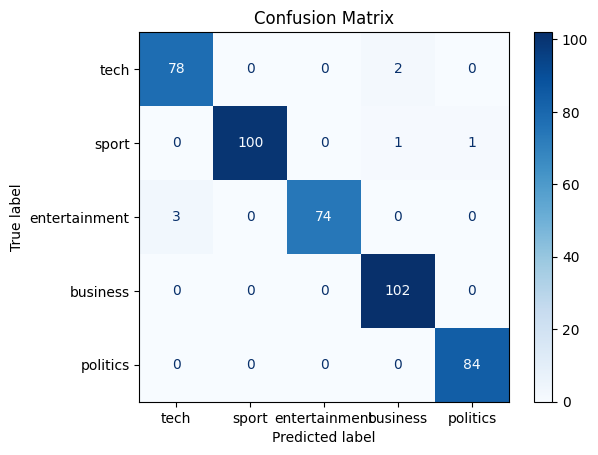

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



# Create a reverse mapping dictionary
reverse_mapping = {0: 'tech', 1: 'sport', 2: 'entertainment', 3: 'business', 4: 'politics'}

# Revert predictions and true labels
reverted_predictions = [reverse_mapping[pred] for pred in predictions]
reverted_true_labels = [reverse_mapping[label] for label in true_labels]

# Calculate confusion matrix
cm = confusion_matrix(reverted_true_labels, reverted_predictions, labels=list(reverse_mapping.values()))

# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(reverse_mapping.values()))
disp.plot(cmap=plt.cm.Blues)  # You can change the colormap if you like
plt.title('Confusion Matrix')
plt.show()

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=d0b555030db537b425acad6a7ba0e7c27d9dc1dd8e4afc9cca74c0596c2409fe
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
from torchviz import make_dot

# Assuming Bert_model is your model and you have sample input data
#input_ids = torch.randint(0, 30522, (1, 100))
#attention_mask = torch.randint(0, 2, (1, 100))
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    break

# Get the model's output
outputs = Bert_model(input_ids, attention_mask)

# Visualize the model
make_dot(outputs.logits, params=dict(Bert_model.named_parameters())).render("bert_model_plot", format="png")

'bert_model_plot.png'

In [ ]:
# Save the model weights
Bert_model.save_weights('bert_model_weights.h5')

# To load the weights back later:
Bert_model.load_weights('bert_model_weights.h5')

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


# Tokenize and Pad Sequences
max_words = 2198  # Vocabulary size
max_len = 100  # Maximum length of sequences
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Split into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)

# Build the LSTM Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    SpatialDropout1D(0.2),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')  # 5 classes for output
])

# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## MODEL COMPARISM

In [17]:
    # Training
start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tr_l,tr_acc, v_l, v_a = train_model(Bert_model, train_loader, val_loader, optimizer, device, epochs=3)
end_time = time.time()
print(f"Time Taken by BERT Transformer: {end_time - start_time} s")

100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Epoch 1/3, Loss: 24.7747, Accuracy: 0.6994
Validation Accuracy: 0.9522


100%|██████████| 23/23 [00:34<00:00,  1.51s/it]


Epoch 2/3, Loss: 6.0747, Accuracy: 0.9761
Validation Accuracy: 0.9691


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


Epoch 3/3, Loss: 1.8914, Accuracy: 0.9909
Validation Accuracy: 0.9719
Time Taken by BERT Transformer: 124.61447548866272 s


In [19]:
# Train the Model
start_time = time.time()
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test))
end_time = time.time()
print(f"Time Taken by LSTM: {end_time - start_time} s")
# Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.2405 - loss: 1.5963 - val_accuracy: 0.3326 - val_loss: 1.5346
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4229 - loss: 1.4513 - val_accuracy: 0.4157 - val_loss: 1.5800
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4847 - loss: 1.2975 - val_accuracy: 0.5730 - val_loss: 1.0199
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6572 - loss: 0.8709 - val_accuracy: 0.6787 - val_loss: 0.8156
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8343 - loss: 0.4902 - val_accuracy: 0.7438 - val_loss: 0.7280
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8617 - loss: 0.4451 - val_accuracy: 0.8022 - val_loss: 0.5382
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9262 - loss: 0.2711 - val_accuracy: 0.7753 - val_loss: 0.6752
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9475 - loss: 0.1871 - val_accuracy: 0.8202 - val_

In [20]:
start_time = time.time()
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))
end_time = time.time()
print(f"Time Taken by LSTM: {end_time - start_time} s")
# Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.8539 - val_loss: 0.8146
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.8472 - val_loss: 0.8331
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9747 - loss: 0.0666 - val_accuracy: 0.8427 - val_loss: 0.7686
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9998 - loss: 0.0043 - val_accuracy: 0.8427 - val_loss: 0.8056
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9974 - loss: 0.0103 - val_accuracy: 0.8472 - val_loss: 0.8147
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 9.5132e-04 - val_accuracy: 0.8494 - val_loss: 0.8110
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 8.0235e-04 - val_accuracy: 0.8472 - val_loss: 0.8460
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 6.9704e-04 - val_accuracy

In [27]:
# Define hyperparameters and their values
hyperparameters = {
    "batch_size": [32, 64],
    "learning_rate": [3e-5, 3e-1],
    "attention_heads": [4, 8],
    "num_hidden_layers": [12, 24],
}

# Generate all combinations (full factorial)
combinations = list(itertools.product(*hyperparameters.values()))
combinations


[(32, 3e-05, 4, 12),
 (32, 3e-05, 4, 24),
 (32, 3e-05, 8, 12),
 (32, 3e-05, 8, 24),
 (32, 0.3, 4, 12),
 (32, 0.3, 4, 24),
 (32, 0.3, 8, 12),
 (32, 0.3, 8, 24),
 (64, 3e-05, 4, 12),
 (64, 3e-05, 4, 24),
 (64, 3e-05, 8, 12),
 (64, 3e-05, 8, 24),
 (64, 0.3, 4, 12),
 (64, 0.3, 4, 24),
 (64, 0.3, 8, 12),
 (64, 0.3, 8, 24)]

In [28]:
for i, (batch_size, learning_rate, attention_heads, num_hidden_layers) in enumerate(combinations):
    print(f"Training model {i+1}/{len(combinations)} with hyperparameters:")
    print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}, Attention Heads: {attention_heads}, Hidden Layers: {num_hidden_layers}")

    # Initialize model with specific hyperparameters
    Bert_model = BertForSequenceClassification.from_pretrained(
        pretrained_model_name_or_path=pretrained_model_name,
        num_labels=num_classes,
    )

    # Adjust model architecture (if necessary)
    Bert_model.config.num_attention_heads = attention_heads
    Bert_model.config.num_hidden_layers = num_hidden_layers

    # Move model to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Bert_model.to(device)

    # Define optimizer with current learning rate
    optimizer = AdamW(Bert_model.parameters(), lr=learning_rate)

    # Train the model and measure training time
    start_time = time.time()
    tr_loss, tr_acc, val_loss, val_acc = train_model(Bert_model, train_loader, val_loader, optimizer, device, epochs=3)
    end_time = time.time()

    # Print results for the current combination
    print(f"Training Complete for Combination {i+1}/{len(combinations)}")
    print(f"Train Loss: {tr_loss}, Train Accuracy: {tr_acc}")
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")
    print(f"Time Taken: {end_time - start_time:.2f} seconds")
    print("-" * 50)

Training model 1/16 with hyperparameters:
Batch Size: 32, Learning Rate: 3e-05, Attention Heads: 4, Hidden Layers: 12


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


Epoch 1/3, Loss: 25.5813, Accuracy: 0.6784
Validation Accuracy: 0.9551


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


Epoch 2/3, Loss: 8.1246, Accuracy: 0.9726
Validation Accuracy: 0.9775


100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


Epoch 3/3, Loss: 2.6372, Accuracy: 0.9895
Validation Accuracy: 0.9719
Training Complete for Combination 1/16
Train Loss: [25.58133751153946, 8.12455826997757, 2.6372007951140404], Train Accuracy: [0.6783707865168539, 0.9726123595505618, 0.9894662921348315]
Validation Loss: [3.456844538450241, 1.0475865975022316, 0.7434413470327854], Validation Accuracy: [0.9550561797752809, 0.9775280898876404, 0.9719101123595506]
Time Taken: 125.93 seconds
--------------------------------------------------
Training model 2/16 with hyperparameters:
Batch Size: 32, Learning Rate: 3e-05, Attention Heads: 4, Hidden Layers: 24


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Epoch 1/3, Loss: 26.3122, Accuracy: 0.6770
Validation Accuracy: 0.9635


100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


Epoch 2/3, Loss: 6.9385, Accuracy: 0.9754
Validation Accuracy: 0.9747


100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


Epoch 3/3, Loss: 2.0489, Accuracy: 0.9881
Validation Accuracy: 0.9691
Training Complete for Combination 2/16
Train Loss: [26.312174260616302, 6.9384655803442, 2.0489126332104206], Train Accuracy: [0.6769662921348315, 0.9754213483146067, 0.988061797752809]
Validation Loss: [3.254258930683136, 0.8022393807768822, 0.5908649787306786], Validation Accuracy: [0.9634831460674157, 0.9747191011235955, 0.9691011235955056]
Time Taken: 126.36 seconds
--------------------------------------------------
Training model 3/16 with hyperparameters:
Batch Size: 32, Learning Rate: 3e-05, Attention Heads: 8, Hidden Layers: 12


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Epoch 1/3, Loss: 25.0319, Accuracy: 0.7051
Validation Accuracy: 0.9551


100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Epoch 2/3, Loss: 7.1809, Accuracy: 0.9726
Validation Accuracy: 0.9719


100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Epoch 3/3, Loss: 2.2098, Accuracy: 0.9888
Validation Accuracy: 0.9607
Training Complete for Combination 3/16
Train Loss: [25.031903624534607, 7.180867254734039, 2.209822576493025], Train Accuracy: [0.7050561797752809, 0.9726123595505618, 0.9887640449438202]
Validation Loss: [3.119338721036911, 0.926699087023735, 0.925017699599266], Validation Accuracy: [0.9550561797752809, 0.9719101123595506, 0.9606741573033708]
Time Taken: 125.93 seconds
--------------------------------------------------
Training model 4/16 with hyperparameters:
Batch Size: 32, Learning Rate: 3e-05, Attention Heads: 8, Hidden Layers: 24


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 1/3, Loss: 26.1687, Accuracy: 0.6917
Validation Accuracy: 0.9579


100%|██████████| 23/23 [00:36<00:00,  1.59s/it]


Epoch 2/3, Loss: 8.1848, Accuracy: 0.9698
Validation Accuracy: 0.9775


100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


Epoch 3/3, Loss: 2.3571, Accuracy: 0.9916
Validation Accuracy: 0.9775
Training Complete for Combination 4/16
Train Loss: [26.168666541576385, 8.18482457101345, 2.3571184165775776], Train Accuracy: [0.6917134831460674, 0.9698033707865169, 0.9915730337078652]
Validation Loss: [3.636396288871765, 0.9807618781924248, 0.7594692595303059], Validation Accuracy: [0.9578651685393258, 0.9775280898876404, 0.9775280898876404]
Time Taken: 127.06 seconds
--------------------------------------------------
Training model 5/16 with hyperparameters:
Batch Size: 32, Learning Rate: 0.3, Attention Heads: 4, Hidden Layers: 12


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 23/23 [00:34<00:00,  1.52s/it]


Epoch 1/3, Loss: 2484.5669, Accuracy: 0.1896
Validation Accuracy: 0.2163


100%|██████████| 23/23 [00:33<00:00,  1.47s/it]


Epoch 2/3, Loss: 1376.7678, Accuracy: 0.2107
Validation Accuracy: 0.2163


100%|██████████| 23/23 [00:34<00:00,  1.49s/it]


Epoch 3/3, Loss: 898.9975, Accuracy: 0.1980
Validation Accuracy: 0.2163
Training Complete for Combination 5/16
Train Loss: [2484.56692302227, 1376.7678394317627, 898.9974822998047], Train Accuracy: [0.1896067415730337, 0.21067415730337077, 0.19803370786516855]
Validation Loss: [714.6641464233398, 248.29505157470703, 314.6241569519043], Validation Accuracy: [0.21629213483146068, 0.21629213483146068, 0.21629213483146068]
Time Taken: 119.20 seconds
--------------------------------------------------
Training model 6/16 with hyperparameters:
Batch Size: 32, Learning Rate: 0.3, Attention Heads: 4, Hidden Layers: 24


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


Epoch 1/3, Loss: 1810.9479, Accuracy: 0.2149
Validation Accuracy: 0.1854


100%|██████████| 23/23 [00:33<00:00,  1.45s/it]


Epoch 2/3, Loss: 848.9394, Accuracy: 0.2128
Validation Accuracy: 0.2163


100%|██████████| 23/23 [00:33<00:00,  1.45s/it]


Epoch 3/3, Loss: 608.6931, Accuracy: 0.2065
Validation Accuracy: 0.2444
Training Complete for Combination 6/16
Train Loss: [1810.9479303359985, 848.9394416809082, 608.693115234375], Train Accuracy: [0.2148876404494382, 0.2127808988764045, 0.20646067415730338]
Validation Loss: [335.6523017883301, 116.56988334655762, 249.25904846191406], Validation Accuracy: [0.1853932584269663, 0.21629213483146068, 0.2443820224719101]
Time Taken: 118.90 seconds
--------------------------------------------------
Training model 7/16 with hyperparameters:
Batch Size: 32, Learning Rate: 0.3, Attention Heads: 8, Hidden Layers: 12


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 23/23 [00:34<00:00,  1.52s/it]


Epoch 1/3, Loss: 1993.6573, Accuracy: 0.1945
Validation Accuracy: 0.2444


100%|██████████| 23/23 [00:34<00:00,  1.50s/it]


Epoch 2/3, Loss: 1126.4090, Accuracy: 0.2121
Validation Accuracy: 0.2163


100%|██████████| 23/23 [00:33<00:00,  1.44s/it]


Epoch 3/3, Loss: 855.3476, Accuracy: 0.2065
Validation Accuracy: 0.2163
Training Complete for Combination 7/16
Train Loss: [1993.6573421955109, 1126.4089679718018, 855.3475522994995], Train Accuracy: [0.19452247191011235, 0.21207865168539325, 0.20646067415730338]
Validation Loss: [458.699951171875, 118.69770622253418, 271.1192932128906], Validation Accuracy: [0.2443820224719101, 0.21629213483146068, 0.21629213483146068]
Time Taken: 118.59 seconds
--------------------------------------------------
Training model 8/16 with hyperparameters:
Batch Size: 32, Learning Rate: 0.3, Attention Heads: 8, Hidden Layers: 24


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 23/23 [00:34<00:00,  1.51s/it]


Epoch 1/3, Loss: 2304.1639, Accuracy: 0.1966
Validation Accuracy: 0.1770


100%|██████████| 23/23 [00:33<00:00,  1.44s/it]


Epoch 2/3, Loss: 1322.2735, Accuracy: 0.1903
Validation Accuracy: 0.1854


100%|██████████| 23/23 [00:33<00:00,  1.45s/it]


Epoch 3/3, Loss: 1320.0744, Accuracy: 0.2008
Validation Accuracy: 0.2163
Training Complete for Combination 8/16
Train Loss: [2304.163901090622, 1322.2735195159912, 1320.0744132995605], Train Accuracy: [0.19662921348314608, 0.19030898876404495, 0.20084269662921347]
Validation Loss: [463.4673385620117, 248.93724060058594, 268.2000961303711], Validation Accuracy: [0.17696629213483145, 0.1853932584269663, 0.21629213483146068]
Time Taken: 116.71 seconds
--------------------------------------------------
Training model 9/16 with hyperparameters:
Batch Size: 64, Learning Rate: 3e-05, Attention Heads: 4, Hidden Layers: 12


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 23/23 [00:36<00:00,  1.59s/it]


Epoch 1/3, Loss: 27.9312, Accuracy: 0.6538
Validation Accuracy: 0.9775


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


Epoch 2/3, Loss: 7.2497, Accuracy: 0.9670
Validation Accuracy: 0.9719


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


Epoch 3/3, Loss: 1.8942, Accuracy: 0.9888
Validation Accuracy: 0.9719
Training Complete for Combination 9/16
Train Loss: [27.931163012981415, 7.249737456440926, 1.894198577851057], Train Accuracy: [0.6537921348314607, 0.9669943820224719, 0.9887640449438202]
Validation Loss: [3.3527269065380096, 0.7991316616535187, 0.6180490832775831], Validation Accuracy: [0.9775280898876404, 0.9719101123595506, 0.9719101123595506]
Time Taken: 126.14 seconds
--------------------------------------------------
Training model 10/16 with hyperparameters:
Batch Size: 64, Learning Rate: 3e-05, Attention Heads: 4, Hidden Layers: 24


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


Epoch 1/3, Loss: 26.9649, Accuracy: 0.6482
Validation Accuracy: 0.9354


100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


Epoch 2/3, Loss: 8.2605, Accuracy: 0.9635
Validation Accuracy: 0.9663


100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


Epoch 3/3, Loss: 2.3811, Accuracy: 0.9902
Validation Accuracy: 0.9607
Training Complete for Combination 10/16
Train Loss: [26.964872777462006, 8.260526731610298, 2.3810561634600163], Train Accuracy: [0.6481741573033708, 0.9634831460674157, 0.9901685393258427]
Validation Loss: [3.678284764289856, 1.2555878907442093, 0.7587934918701649], Validation Accuracy: [0.9353932584269663, 0.9662921348314607, 0.9606741573033708]
Time Taken: 126.36 seconds
--------------------------------------------------
Training model 11/16 with hyperparameters:
Batch Size: 64, Learning Rate: 3e-05, Attention Heads: 8, Hidden Layers: 12


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


Epoch 1/3, Loss: 24.5821, Accuracy: 0.7268
Validation Accuracy: 0.9382


100%|██████████| 23/23 [00:36<00:00,  1.59s/it]


Epoch 2/3, Loss: 8.3031, Accuracy: 0.9635
Validation Accuracy: 0.9719


100%|██████████| 23/23 [00:36<00:00,  1.59s/it]


Epoch 3/3, Loss: 2.6419, Accuracy: 0.9881
Validation Accuracy: 0.9691
Training Complete for Combination 11/16
Train Loss: [24.58208853006363, 8.30305352807045, 2.64189525693655], Train Accuracy: [0.7268258426966292, 0.9634831460674157, 0.988061797752809]
Validation Loss: [3.5361161828041077, 1.1678613498806953, 0.7924330346286297], Validation Accuracy: [0.9382022471910112, 0.9719101123595506, 0.9691011235955056]
Time Taken: 125.74 seconds
--------------------------------------------------
Training model 12/16 with hyperparameters:
Batch Size: 64, Learning Rate: 3e-05, Attention Heads: 8, Hidden Layers: 24


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Epoch 1/3, Loss: 25.5569, Accuracy: 0.6721
Validation Accuracy: 0.9466


100%|██████████| 23/23 [00:36<00:00,  1.59s/it]


Epoch 2/3, Loss: 8.1447, Accuracy: 0.9733
Validation Accuracy: 0.9719


100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Epoch 3/3, Loss: 2.4186, Accuracy: 0.9902
Validation Accuracy: 0.9719
Training Complete for Combination 12/16
Train Loss: [25.55694055557251, 8.14467340707779, 2.4185934253036976], Train Accuracy: [0.6720505617977528, 0.973314606741573, 0.9901685393258427]
Validation Loss: [3.6584801077842712, 0.9910557866096497, 0.704739149659872], Validation Accuracy: [0.9466292134831461, 0.9719101123595506, 0.9719101123595506]
Time Taken: 125.59 seconds
--------------------------------------------------
Training model 13/16 with hyperparameters:
Batch Size: 64, Learning Rate: 0.3, Attention Heads: 4, Hidden Layers: 12


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


Epoch 1/3, Loss: 1920.4713, Accuracy: 0.2008
Validation Accuracy: 0.2163


100%|██████████| 23/23 [00:34<00:00,  1.49s/it]


Epoch 2/3, Loss: 1338.5207, Accuracy: 0.1973
Validation Accuracy: 0.2444


100%|██████████| 23/23 [00:32<00:00,  1.43s/it]


Epoch 3/3, Loss: 1459.1005, Accuracy: 0.1924
Validation Accuracy: 0.2163
Training Complete for Combination 13/16
Train Loss: [1920.4712541103363, 1338.5207405090332, 1459.1005096435547], Train Accuracy: [0.20084269662921347, 0.1973314606741573, 0.19241573033707865]
Validation Loss: [335.21368408203125, 232.57624435424805, 429.39723205566406], Validation Accuracy: [0.21629213483146068, 0.2443820224719101, 0.21629213483146068]
Time Taken: 118.84 seconds
--------------------------------------------------
Training model 14/16 with hyperparameters:
Batch Size: 64, Learning Rate: 0.3, Attention Heads: 4, Hidden Layers: 24


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 23/23 [00:34<00:00,  1.49s/it]


Epoch 1/3, Loss: 2283.4421, Accuracy: 0.2114
Validation Accuracy: 0.2444


100%|██████████| 23/23 [00:34<00:00,  1.49s/it]


Epoch 2/3, Loss: 1114.7475, Accuracy: 0.2079
Validation Accuracy: 0.1770


100%|██████████| 23/23 [00:33<00:00,  1.44s/it]


Epoch 3/3, Loss: 1284.6802, Accuracy: 0.1931
Validation Accuracy: 0.1770
Training Complete for Combination 14/16
Train Loss: [2283.4421306848526, 1114.7474689483643, 1284.6802024841309], Train Accuracy: [0.21137640449438203, 0.20786516853932585, 0.1931179775280899]
Validation Loss: [321.90485763549805, 452.2907028198242, 231.85772705078125], Validation Accuracy: [0.2443820224719101, 0.17696629213483145, 0.17696629213483145]
Time Taken: 117.48 seconds
--------------------------------------------------
Training model 15/16 with hyperparameters:
Batch Size: 64, Learning Rate: 0.3, Attention Heads: 8, Hidden Layers: 12


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 23/23 [00:33<00:00,  1.48s/it]


Epoch 1/3, Loss: 2088.5245, Accuracy: 0.1959
Validation Accuracy: 0.2444


100%|██████████| 23/23 [00:33<00:00,  1.46s/it]


Epoch 2/3, Loss: 1442.7867, Accuracy: 0.1847
Validation Accuracy: 0.2444


100%|██████████| 23/23 [00:33<00:00,  1.47s/it]


Epoch 3/3, Loss: 589.0919, Accuracy: 0.2149
Validation Accuracy: 0.1770
Training Complete for Combination 15/16
Train Loss: [2088.5244582891464, 1442.7866592407227, 589.0918884277344], Train Accuracy: [0.19592696629213482, 0.18469101123595505, 0.2148876404494382]
Validation Loss: [293.0500717163086, 162.99757385253906, 63.407405853271484], Validation Accuracy: [0.2443820224719101, 0.2443820224719101, 0.17696629213483145]
Time Taken: 116.93 seconds
--------------------------------------------------
Training model 16/16 with hyperparameters:
Batch Size: 64, Learning Rate: 0.3, Attention Heads: 8, Hidden Layers: 24


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 23/23 [00:34<00:00,  1.50s/it]


Epoch 1/3, Loss: 1610.3342, Accuracy: 0.2149
Validation Accuracy: 0.1770


100%|██████████| 23/23 [00:33<00:00,  1.46s/it]


Epoch 2/3, Loss: 1285.7520, Accuracy: 0.1875
Validation Accuracy: 0.1770


100%|██████████| 23/23 [00:33<00:00,  1.46s/it]


Epoch 3/3, Loss: 798.8407, Accuracy: 0.2001
Validation Accuracy: 0.2163
Training Complete for Combination 16/16
Train Loss: [1610.3342401981354, 1285.7519721984863, 798.8407468795776], Train Accuracy: [0.2148876404494382, 0.1875, 0.20014044943820225]
Validation Loss: [308.6497116088867, 176.80707359313965, 163.39073753356934], Validation Accuracy: [0.17696629213483145, 0.17696629213483145, 0.21629213483146068]
Time Taken: 118.41 seconds
--------------------------------------------------
